In [1]:
from pathlib import Path

import numpy as np
import safetensors
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt


In [2]:
st = safetensors.safe_open('./data/model-verybighalfbrain2e60.safetensors', framework='numpy')

tags = np.array([t.strip() for t in open('./data/tags.txt', 'rt').read().split('\n')][:-1])
tags2id = {t: i for i, t in enumerate(tags)}

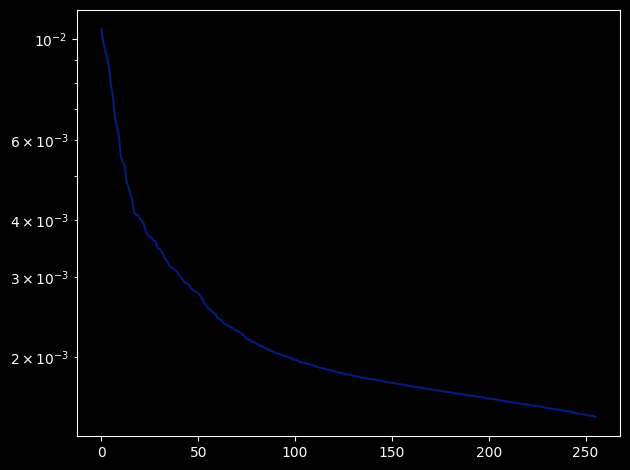

In [3]:
X = st.get_tensor('embeddings.weight')
# You might want to play with, ie disabling these
X /= np.linalg.norm(X, axis=1)[:, None]

pca = PCA(256)
Xt = pca.fit_transform(X)
#Xt /= np.linalg.norm(Xt, axis=1)[:, None] # <- same here

plt.semilogy(pca.explained_variance_)

In [4]:
sel_tags = ['trio', 'trio_focus', 'duo', 'duo_focus', 'solo', 'solo_focus', 'threesome', 'foursome']

sel_idxs = [tags2id[t] for t in sel_tags if t in tags2id]
sel_idxs.sort()
sel_tags = [tags[i] for i in sel_idxs]
print(' '.join(sel_tags))

solo duo solo_focus trio threesome duo_focus foursome trio_focus


Text(0.5, 0, 'score')

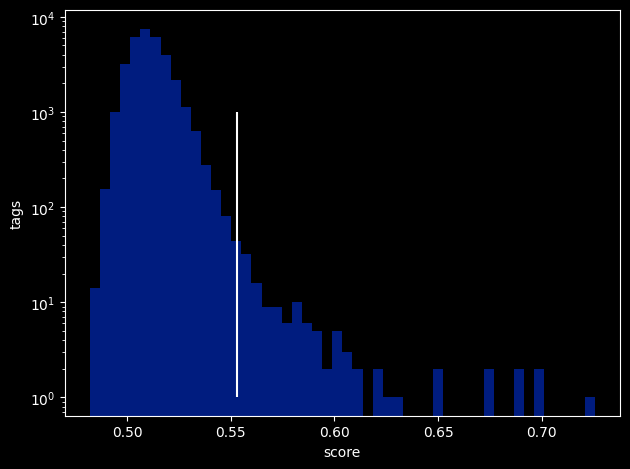

In [5]:
# Select neighboring tags similar to foreground one
n_neighbors = 128
n_neighbors_display = 64
temp = 2
lp = 64 # 1: sum of probabilities, ->inf: max

neigh_score = Xt @ Xt[sel_idxs].T


# Sigmoid -> power -> marginal sum over selected points
#neigh_score = 1/(1 + np.exp(-neigh_score))
#neigh_score = (neigh_score ** lp).mean(axis=1) ** (1/lp)

# Same, more stable?
neigh_score = -np.log1p(np.exp(-temp * neigh_score))
neigh_score = np.exp(neigh_score * lp).mean(axis=1) ** (1/lp)

#neigh_score = np.linalg.norm(Xt @ Xt[sel_idxs].T, ord=1.5, axis=1)
thresh = np.sort(neigh_score)[-n_neighbors]
neigh_idxs = np.where(neigh_score > thresh)[0]
plt.hist(neigh_score, 50, log=True);
plt.vlines(thresh, 1, 1e3)
plt.ylabel('tags')
plt.xlabel('score')

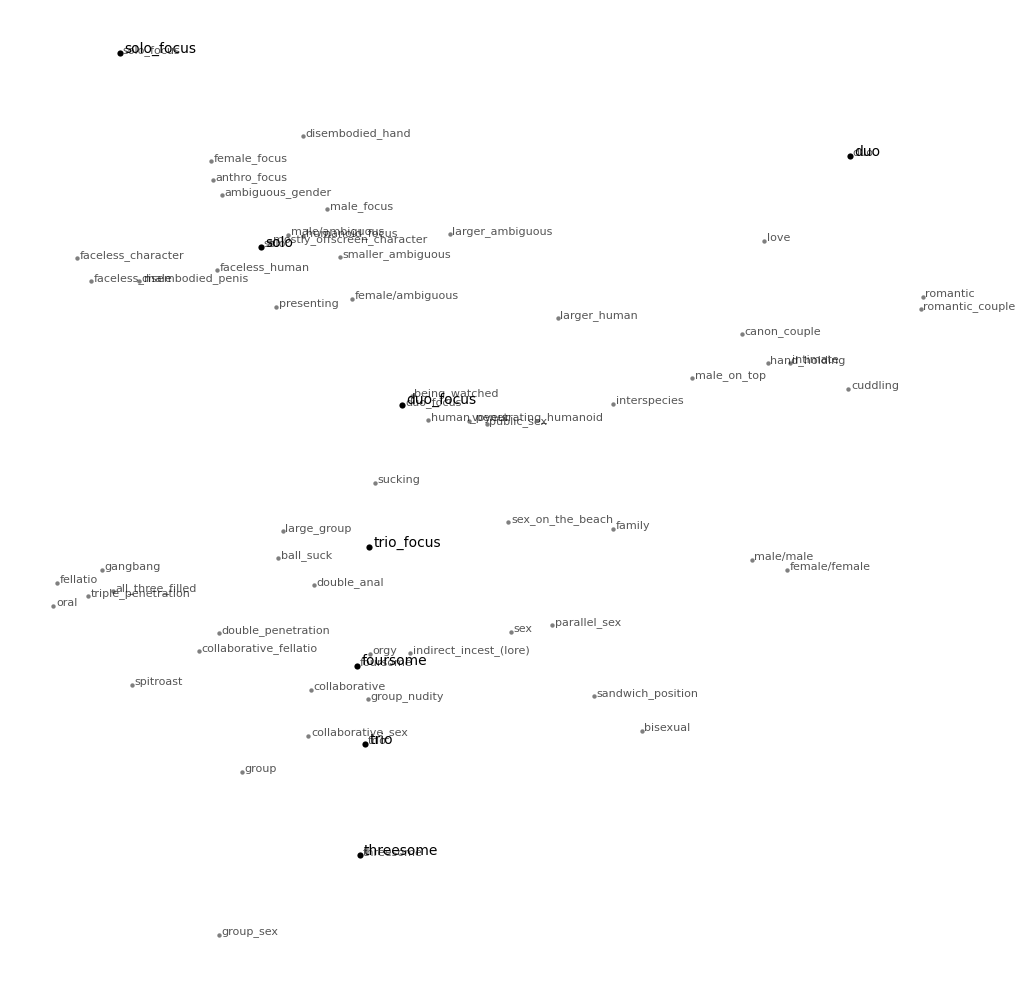

In [6]:
idxs = np.concatenate([sel_idxs, neigh_idxs])

# Local PCA
X2 = Xt[idxs].copy()
X2 -= X2.mean(0)
X2 /= np.linalg.norm(X2, axis=1)[:, None]
X2t = PCA(2).fit_transform(X2)[:,::-1]

dark_mode = False
fg_color = 'white' if dark_mode else 'black'
bg_color = 'black' if dark_mode else 'white'

f, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
f.set_facecolor(bg_color)

dx = 0.01
ax.scatter(*X2t[:len(sel_idxs)].T, 
           c=fg_color, linewidth=0, s=20)
for i, t in enumerate(sel_tags):
    ax.annotate(t, tuple(X2t[i,:] + [dx*0.5, dx*0.25]), 
                color=fg_color)

ax.scatter(*X2t[len(sel_idxs):len(sel_idxs) + n_neighbors_display].T, 
           c=fg_color, linewidth=0, s=10, alpha=0.5)
for i, t in enumerate(tags[neigh_idxs[:n_neighbors_display]], len(sel_idxs)):
    ax.annotate(t, tuple(X2t[i,:] + [dx*0.3, dx*0.3/2]), 
                color=fg_color, fontsize=8, alpha=2/3)

f.tight_layout()

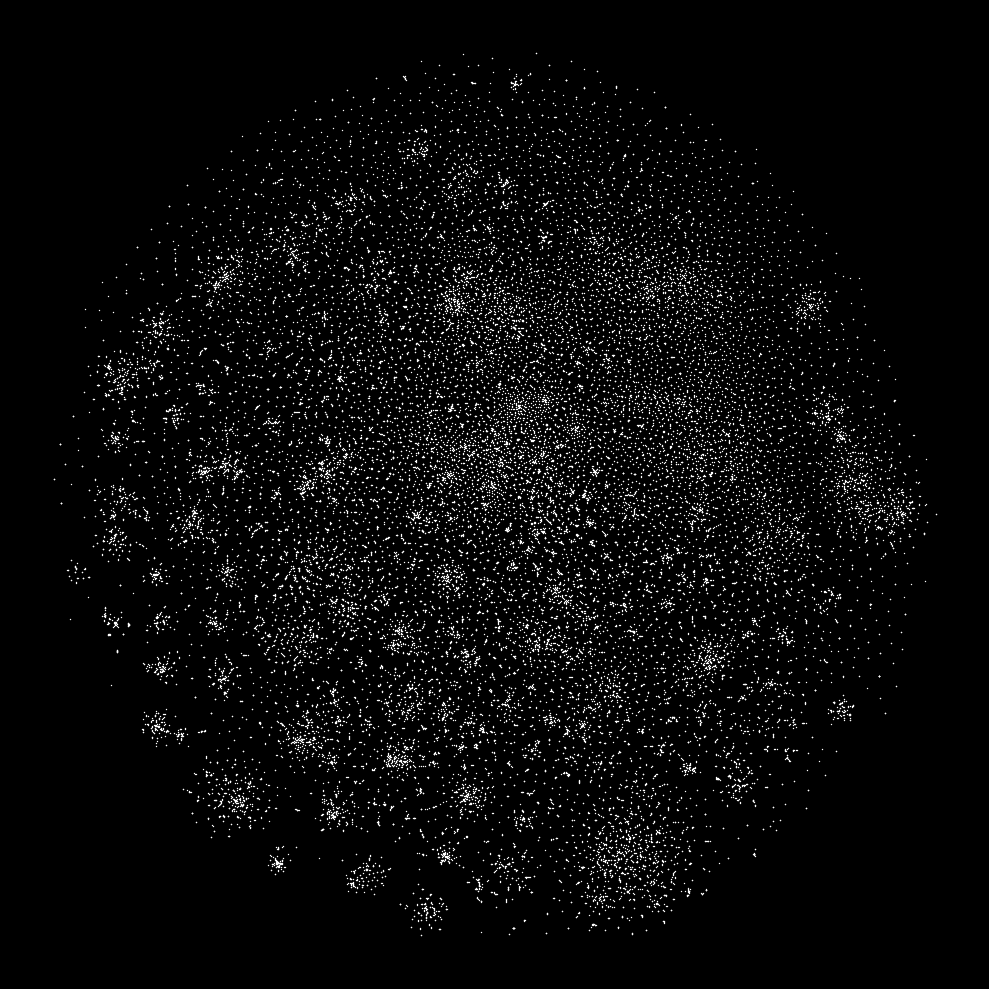

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE()
Xt2 = tsne.fit_transform(Xt)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.scatter(
    *Xt2.T,
    linewidth=0,
    color='white',
    s=1
)